In [32]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
import string
import warnings
warnings.filterwarnings('ignore')


In [33]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set on axis 0
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

df_train = pd.read_csv('../titanic/train.csv')
df_test = pd.read_csv('../titanic/test.csv')
df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_train, df_test]

print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [34]:
df_all_corr = df_all.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
6,Age,Age,1.000000
9,Age,Pclass,0.408106
17,Age,SibSp,0.243699
22,Age,Fare,0.178740
25,Age,Parch,0.150917
29,Age,Survived,0.077221
41,Age,PassengerId,0.028814


In [35]:
df_all['Age'] = df_all.groupby(["Pclass", "Sex"])["Age"].apply(lambda x: x.fillna(x.median()))

In [36]:
df_all

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,25.0,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236
1305,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758
1306,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262
1307,25.0,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309


In [37]:
df_all['Embarked'] = df_all['Embarked'].fillna('S')

In [38]:
df_all[df_all['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [39]:
df_all_corr = df_all.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Fare']

,Feature 1,Feature 2,Correlation Coefficient
2,Fare,Fare,1.000000
7,Fare,Pclass,0.558629
15,Fare,Survived,0.257307
17,Fare,Parch,0.221539
22,Fare,Age,0.200039
24,Fare,SibSp,0.160238
40,Fare,PassengerId,0.031428


In [73]:
a = df_all.groupby(["Pclass", "Parch", "Age"])["Fare"].fillna(df_all.groupby(["Pclass", "Parch", "Age"])["Fare"].mean())
df_all['Fare'] = df_all.groupby(["Pclass", "Parch", "Age"])["Fare"].apply(lambda x: x.fillna(x.mean()))

ValueError: 

In [76]:
a.isna()[a.isna() != False]

1043    True
Name: Fare, dtype: bool

In [108]:
df_all.loc[1043, "Fare"]= 6.2375

In [109]:
df_all.iloc[1043]["Fare"]

6.2375

In [86]:
a = df_all.groupby(["Pclass", "Parch", "Age"])["Fare"].mean()

In [97]:
a[(3, 0,)]

Age
5.0     12.4750
11.0    18.7875
12.0    11.2417
13.0     7.2292
14.0     9.4403
         ...   
61.0     6.2375
63.0     9.5875
65.0     7.7500
70.5     7.7500
74.0     7.7750
Name: Fare, Length: 64, dtype: float64

In [41]:
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

In [42]:
df_all_decks = df_all.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

In [43]:
df_all_decks

Deck     A   B   C   D      E         F     G   M            T
Pclass   1   1   1   1  2   1  2  3   2  3  3   1    2    3  1
Count   22  65  94  40  6  34  4  3  13  8  5  67  254  693  1

In [44]:
df_all_decks.columns

MultiIndex([('A', 1),
            ('B', 1),
            ('C', 1),
            ('D', 1),
            ('D', 2),
            ('E', 1),
            ('E', 2),
            ('E', 3),
            ('F', 2),
            ('F', 3),
            ('G', 3),
            ('M', 1),
            ('M', 2),
            ('M', 3),
            ('T', 1)],
           names=['Deck', 'Pclass'])

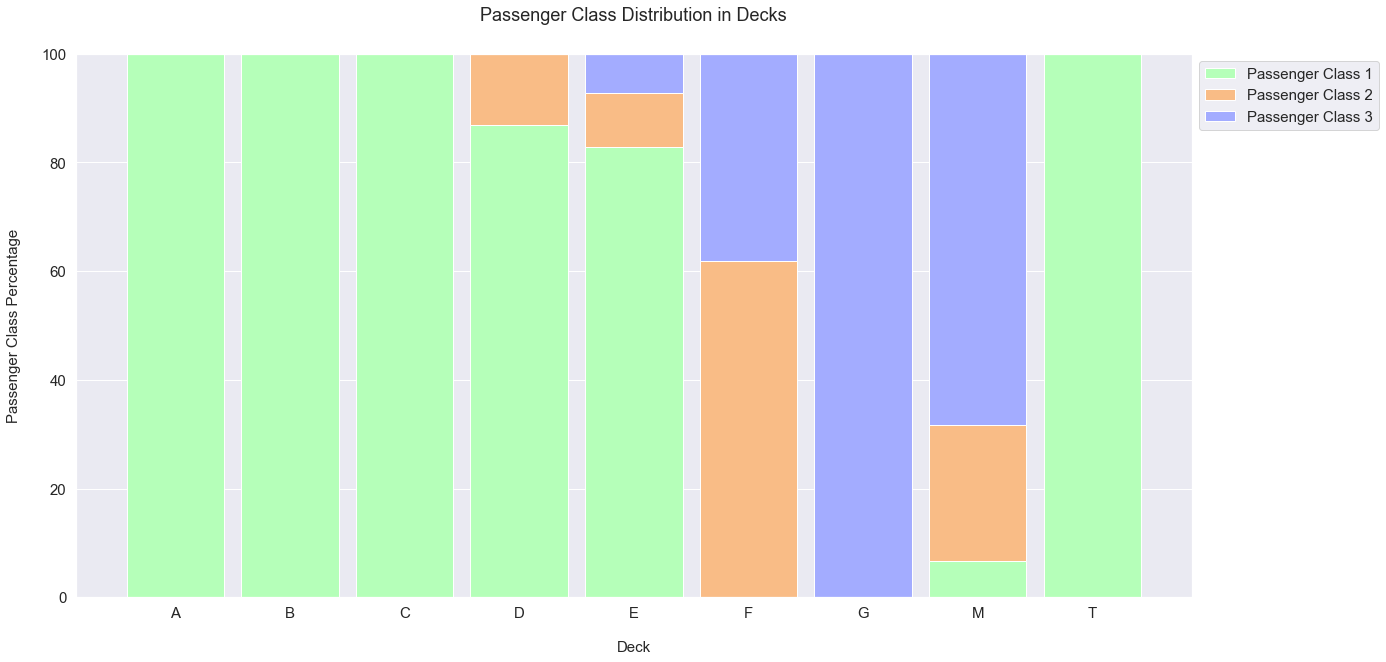

In [45]:
def get_pclass_dist(df):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]    
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()    

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)

In [46]:
idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'

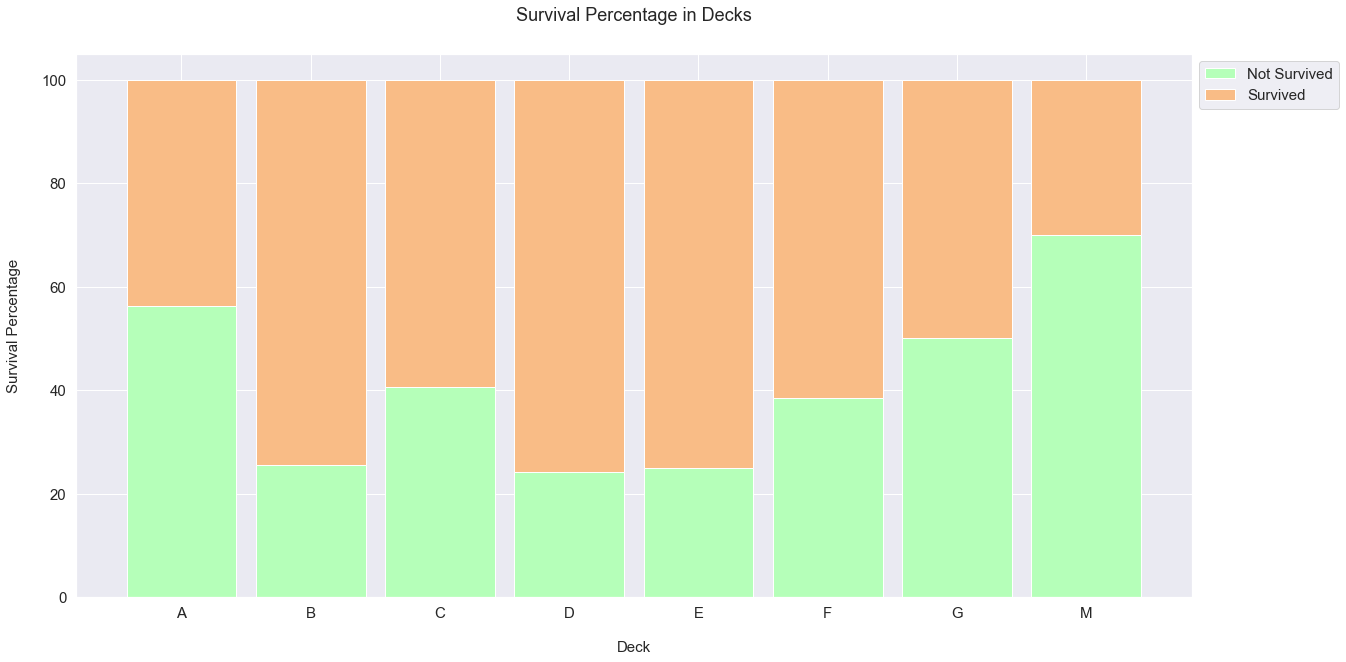

In [47]:
df_all_decks_survived = df_all.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)

In [48]:
df_all

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Deck
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,M
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,C
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,M
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,C
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,25.0,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236,M
1305,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758,C
1306,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262,M
1307,25.0,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309,M


In [49]:
def clear_cabin(x):
    a = np.array([item[1:] for item in x.split(" ")])
    a = np.array(a[a!= ""], dtype = int)
    if len(a) == 0:
        res = 0
    else: 
        res = int(a.mean())
    return res


data_cabin = np.array(df_all["Cabin"].fillna("N0").apply(clear_cabin))

df_all["number_of_cabin"] = data_cabin

In [50]:
from sklearn.metrics import mean_squared_error
import re
from nltk.corpus import stopwords
import pymorphy2
morph_stories = pymorphy2.MorphAnalyzer()

stops = set(stopwords.words("english")) | set(stopwords.words("russian"))
def review_to_wordlist(review):
    #1)
    review_text = re.sub("[^а-яА-Яa-zA-Z]"," ", review)
    #2)
    words = review_text.lower().split()
    #3)
#     words = [w for w in words if not w in stops]
    #4)
    words = [morph_stories.parse(w)[0].normal_form for w in words ]
    return(words)

In [51]:
first_name = []
title = []
second_name = []
third_name = []
for row in df_all["Name"].values:
    second_name.append(review_to_wordlist(row.split(",")[0])[0])
    if len(row.split(",")) > 1:
        if len(row.split(",")[1].split(" ")) > 1:
            title.append(review_to_wordlist(row.split(",")[1].split(" ")[1])[0])
            first_name.append(review_to_wordlist(row.split(",")[1].split(" ")[2])[0])
            if len(row.split(",")[1].split(" ")) > 3:
                if len(review_to_wordlist(row.split(",")[1].split(" ")[3])) > 0:
                    third_name.append(review_to_wordlist(row.split(",")[1].split(" ")[3])[0])
                else:
                    third_name.append(np.nan)
            else:
                third_name.append(np.nan)
        else: 
            title.append(np.nan)
            first_name.append(np.nan)
            third_name.append(np.nan)
    else: 
        title.append(np.nan)
        first_name.append(np.nan)
        third_name.append(np.nan)
df_all["first_name"] = first_name
df_all["second_name"] = second_name
df_all["title"] = title
df_all["third_name"] = third_name

In [52]:
data_ticket = np.array(df_all["Ticket"].apply(lambda x: x.split(" ")[-1]))
data_ticket[data_ticket == "LINE"] = 0
data_ticket = np.array(data_ticket, dtype = int)
df_all["ticket"] = data_ticket

In [55]:
df_all.drop(columns = ["Name", "Ticket", "Cabin", "third_name"], inplace= True)

In [110]:
# Dropping the Cabin feature

df_train, df_test = divide_df(df_all)
dfs = [df_train, df_test]

for df in dfs:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
Age                891 non-null float64
Embarked           891 non-null object
Fare               891 non-null float64
Parch              891 non-null int64
PassengerId        891 non-null int64
Pclass             891 non-null int64
Sex                891 non-null object
SibSp              891 non-null int64
Survived           891 non-null float64
Deck               891 non-null object
number_of_cabin    891 non-null int64
first_name         891 non-null object
second_name        891 non-null object
title              891 non-null object
ticket             891 non-null int64
dtypes: float64(3), int64(6), object(6)
memory usage: 104.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 891 to 1308
Data columns (total 14 columns):
Age                418 non-null float64
Embarked           418 non-null object
Fare               418 non-null float64
Parch            